이번 장에서 다룰 주제는 가중치 매개변수의 최적값을 탐색하는 방법, 가중치 매개변수 초깃값, 하이퍼파라미터 설정 방법 등, 모두가 신경망 학습에서 중요한 주제입니다. 오버피팅의 대응책인 가중치 감소와 드롭아웃 등의 정규화 방법도 간략히 설명하고 구현해봅니다. 마지막으로 최근 많은 연구에서 사용하는 배치 정규화도 짧게 알아봅니다. 이번 장에서 설명하는 기법을 이용하면 신경망(딥러닝) 학습의 효율과 정확도를 높일 수 있습니다.

- 신경망 학습의 목적은 손실 함수의 값을 가능한 한 낮추는 매개변수를 찾는 것이었죠. 이는 곧 매개변수의 최적값을 찾는 문제이며, 이러한 문제를 푸는 것을 최적화 optimization라 합니다. 안타깝게도 신경망 최적화는 굉장히 어려운 문제입니다. 매개변수 공간은 매우 넓고 복잡해서 최적의 솔루션은 쉽게 못 찾으니까요. 수식을 풀어 순식간에 최솟값을 구하는 방법 같은 것은 없습니다. 게다가 심층 신경망에서는 매개변수의 수가 엄청나게 많아져서 사태는 더욱 심각해집니다.

# SGD 확률적 경사 하강법

In [1]:
class SGD:
    def __init__(self,lr=0.01):
        self.lr=lr
    
    def update(self, params,grads):
        for key in params.keys():
            params[key] -= self.lr*grad[key]

- 초기화 때 받는 인수인 lr은 learning rate를 뜻합니다. 이 learning rate를 인스턴스 변수로 유지합니다. update(params, grads) 메서드는 SGD 과정에서 반복해서 불립니다. 인수인 params와 grads는 (지금까지의 신경망 구현과 마찬가지로) 딕셔너리 변수입니다. SGD 클래스를 사용하면 신경망 매개변수의 진행을 다음과 같이 수행할 수 있습니다.

- 대부분의 딥러닝 프레임워크는 다양한 최적화 기법을 구현해 제공하며, 원하는 기법으로 쉽게 바꿀 수 있는 구조로 되어 있습니다.

# SGD 단점
- SGD는 단순하고 구현도 쉽지만 문제에 따라서는 비효율적일 때가 있습니다.

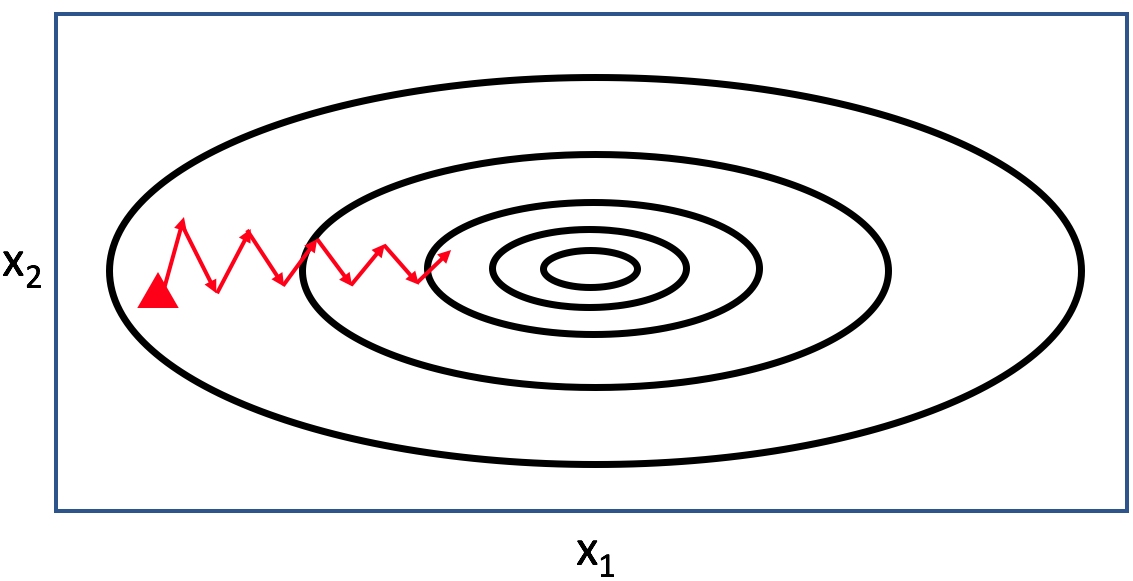  
- 상당히 비효율적인 움직입입니다. 즉, SGD의 단점은 비등방성 anisotropy 함수 (방향에 따라 성질, 즉 여기에서는 기울기가 달라지는 함수)에서는 탐색 경로가 비효율적이라는 것입니다. 이럴 때는 SGD같이 무작정 기울어진 방향으로 진행하는 단순한 방식보다 더 영리한 묘안이 간절해집니다. 또한, SGD가 지그재그로 탐색하는 근본 원인은 기울어진 방향이 보낼의 최솟값과 다른 방향을 가리켜서라는 점도 생각해볼 필요가 있습니다.  
- 이제부터 SGD의 이러한 단점을 개선해주는 모멘텀, AdaGrad, Adam이라는 세 방법을 소개할 것입니다.

# 모멘텀  
- 기울기 방향으로 힘을 받아 물체가 가속된다는 물리 법칙을 나타낸다.

In [2]:
class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

인스턴스 변수 v가 물체의 속도입니다. v는 초기화 때는 아무 값도 담지 않고, 대신 update()가 처음 호출될 때 매개변수와 같은 구조의 데이터를 딕셔너리 변수로 저장합니다.

# AdaGrad
- 신경망 학습에서는 학습률 값이 중요합니다. 이 값이 너무 작으면 학습 시간이 너무 길어지고, 반대로 너무 크면 발산하여 학습이 제대로 이뤄지지 않습니다.
 
- 이 학습률을 정하는 효과적 기술로 학습률 감소 learning rate decay가 있습니다. 이는 학습을 진행하면서 학습률을 점차 줄여가는 방법입니다. 처음에는 크게 학습하다가 조금씩 작게 학습한다는 얘기로, 실제 신경망 학습에 자주 쓰입니다.  

- 학습률을 서서히 낮추는 가장 간단한 방법은 매개변수 '전체'의 학습률 값을 일괄적으로 낮추는 것이겠죠. 이를 더욱 발전시킨 것이 AdaGrad입니다. AdaGrad는 과거의 기울기를 제곱하여 계속 더해갑니다. 그래서 학습을 진행할수록 갱신 강도가 약해집니다. 실제로 무한히 계속학습한다면 어느 순간 갱신량이 0이 되어 전혀 갱신되지 않게 되죠. 이 문제를 개선한 기법으로서 RMSProp이라는 방법이 있습니다. RMSProp은 과거의 모든 기울기를 균일하게 더해가는 것이 아니라, 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영합니다. 이를 지수이동평균 Exponential Moving Average, EMA이라 하여, 과거 기울기의 반영 규모를 기하급수적으로 감소시킵니다.  

- AdaGrad는 '각각의' 매개변수에 '맞춤형'값을 만들어줍니다.

In [3]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

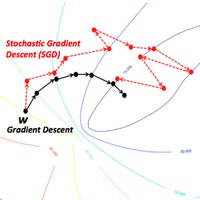

# Adam
- 모멘텀은 공이 그릇 바닥을 구르는 듯한 움직임을 보였습니다. AdaGrad는 매개변수의 원소마다 적응적으로 갱신 정도를 조정했습니다. 그럼 혹시 이 두 기법을 융합하면 어떻게 될까요? 이런 생각에서 출발한 기법이 바로 Adam 입니다.  

- Adam은 2015년에 제안된 새로운 방법입니다. 그 이론은 다소 복잡하지만 직관적으로는 모멘텀과 AdaGrad를 융합한 듯한 방법입니다. 이 두 방법의 이점을 조합했다면 매개변수 공간을 효율적으로 탐색해줄 것으로 기대해도 좋습니다. 또, 하이퍼파라미터의 '편향 보정'이 진행된다는 점도 Adam의 특징입니다.

- Adam 갱신 과정도 그릇 바닥을 구르듯 움직입니다. 모멘텀과 비슷한 패턴인데, 모멘텀 때보다 공의 좌우 흔들림이 적습이다. 이는 학습의 갱신 강도를 적응적으로 조정해서 얻는 혜택입니다.

- Adam은 하이퍼파라미터를 3개 설정합니다. 하나는 지금까지의 학습률(논문에서는 알파a 로 등장), 나머지 두 개는 일차 모멘텀용 계수 b1과 이차 모멘텀용 계수 b2입니다. 논문에 따르면 기본 설정값은 b1은 0.9, b2는 0.999이며, 이 값이면 많은 경우에 좋은 결과를 얻을 수 있습니다.

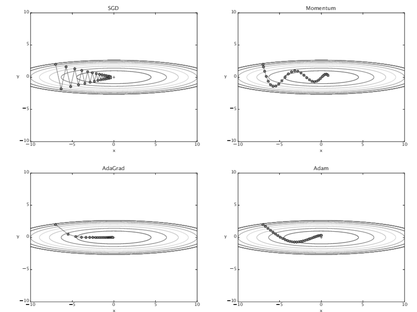

===========iteration:0===========
SGD:2.316916790953763
Momentum:2.326328807061193
AdaGrad:2.1995397812547646
Adam:2.359868878295398
===========iteration:100===========
SGD:1.6056851225063078
Momentum:0.4688587882397182
AdaGrad:0.12569694693148595
Adam:0.2866869496831621
===========iteration:200===========
SGD:0.7733691557273301
Momentum:0.1518099544321439
AdaGrad:0.059795435619053844
Adam:0.098911118666752
===========iteration:300===========
SGD:0.5589893370857302
Momentum:0.25870221927846837
AdaGrad:0.1150956266861537
Adam:0.1615846158602411
===========iteration:400===========
SGD:0.4936458415780276
Momentum:0.18243314730331275
AdaGrad:0.09580293168992789
Adam:0.16166664554333565
===========iteration:500===========
SGD:0.43177757450486076
Momentum:0.15732298282078439
AdaGrad:0.07997723409608296
Adam:0.09683566789654592
===========iteration:600===========
SGD:0.43327759944485456
Momentum:0.19282049224890668
AdaGrad:0.09513571727240511
Adam:0.10168358172480765
===========iteration:700=

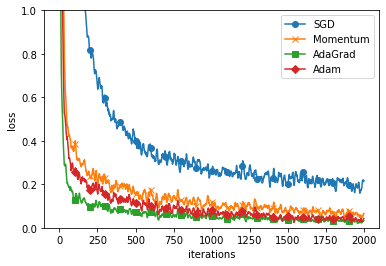

In [4]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


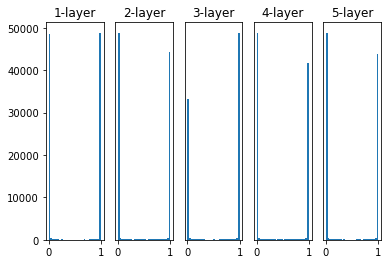

In [14]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    #w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    #w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
    node_num=100
    w = np.random.randn(node_num, node_num) * np.sqrt(node_num)

    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


- 각 층의 활성화값들이 0과 1에 치우쳐 분포되어 있군요. 여기에서 사용한 시그모이드 함수는 그 출력이 0에 가까워지자 (또는 1에 가까워지자) 그 미분은 0에 다가갑니다. 그래서 데이터가 0과 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다가 사라집니다. 이것이 기울기 소실 gradient vanishing이라 알려진 문제입니다. 층으 릭ㅍ게 하는 딥러닝에서는 기울기 소실은 더 심각한 문제가 될 수 있습니다.

- 각 층의 활성화값은 적당히 고루 분포되어야 합니다. 층과 층 사이에 적당하게 다양한 데이터가 흐르게 해야 신경망 학습이 효율적으로 이뤄지기 때문입니다. 반대로 치우친 데이터가 흐르면 기울기 소실이나 표현력 제한 문제에 빠져서 학습이 잘 이뤄지지 않는 경우가 생깁니다.

# 배치 정규화
- 앞 절에서는 각 층의 활성화값 분포를 관찰해보며, **가중치의 초깃값을 적절히 설정하면 각 층의 활성화값 분포가 적당히 퍼지면서 학습이 원활하게 수행됨을 배웠습니다.** 그렇다면 각 층이 활성화를 적당히 퍼뜨리도록 '강제'해보면 어떨까요? 실은 배치 정규화 Batch normalization가 그런 아이디어에서 출발한 방법입니다.

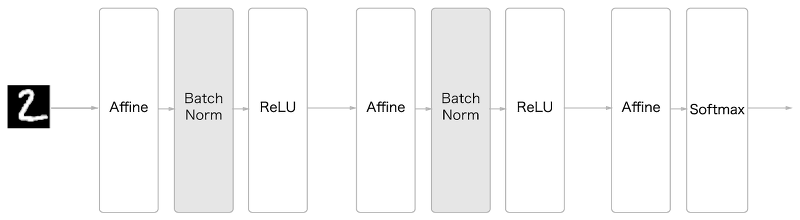

============== 1/16 ==============
epoch:0 | 0.105 - 0.085


..\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
..\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.093
epoch:2 | 0.097 - 0.107
epoch:3 | 0.097 - 0.116
epoch:4 | 0.097 - 0.141
epoch:5 | 0.097 - 0.168
epoch:6 | 0.097 - 0.183
epoch:7 | 0.097 - 0.201
epoch:8 | 0.097 - 0.212
epoch:9 | 0.097 - 0.23
epoch:10 | 0.097 - 0.255
epoch:11 | 0.097 - 0.275
epoch:12 | 0.097 - 0.28
epoch:13 | 0.097 - 0.299
epoch:14 | 0.097 - 0.315
epoch:15 | 0.097 - 0.342
epoch:16 | 0.097 - 0.347
epoch:17 | 0.097 - 0.361
epoch:18 | 0.097 - 0.374


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.399
============== 2/16 ==============
epoch:0 | 0.097 - 0.114
epoch:1 | 0.097 - 0.11
epoch:2 | 0.097 - 0.163
epoch:3 | 0.097 - 0.19
epoch:4 | 0.097 - 0.207
epoch:5 | 0.097 - 0.239
epoch:6 | 0.097 - 0.261
epoch:7 | 0.097 - 0.29
epoch:8 | 0.097 - 0.318
epoch:9 | 0.097 - 0.34
epoch:10 | 0.097 - 0.371
epoch:11 | 0.097 - 0.374
epoch:12 | 0.097 - 0.407
epoch:13 | 0.097 - 0.425
epoch:14 | 0.097 - 0.443
epoch:15 | 0.097 - 0.468
epoch:16 | 0.097 - 0.491
epoch:17 | 0.097 - 0.499


No handles with labels found to put in legend.


epoch:18 | 0.097 - 0.504
epoch:19 | 0.097 - 0.523
============== 3/16 ==============
epoch:0 | 0.126 - 0.085
epoch:1 | 0.292 - 0.096
epoch:2 | 0.482 - 0.143
epoch:3 | 0.562 - 0.186
epoch:4 | 0.65 - 0.223
epoch:5 | 0.7 - 0.261
epoch:6 | 0.753 - 0.297
epoch:7 | 0.8 - 0.326
epoch:8 | 0.834 - 0.365
epoch:9 | 0.851 - 0.401
epoch:10 | 0.887 - 0.433
epoch:11 | 0.906 - 0.453
epoch:12 | 0.918 - 0.489
epoch:13 | 0.932 - 0.529
epoch:14 | 0.943 - 0.547
epoch:15 | 0.954 - 0.577
epoch:16 | 0.961 - 0.59
epoch:17 | 0.972 - 0.604
epoch:18 | 0.971 - 0.621


No handles with labels found to put in legend.


epoch:19 | 0.977 - 0.633
============== 4/16 ==============
epoch:0 | 0.127 - 0.099
epoch:1 | 0.246 - 0.103
epoch:2 | 0.347 - 0.141
epoch:3 | 0.432 - 0.232
epoch:4 | 0.501 - 0.316
epoch:5 | 0.55 - 0.373
epoch:6 | 0.6 - 0.432
epoch:7 | 0.635 - 0.483
epoch:8 | 0.667 - 0.523
epoch:9 | 0.693 - 0.561
epoch:10 | 0.705 - 0.595
epoch:11 | 0.722 - 0.618
epoch:12 | 0.743 - 0.65
epoch:13 | 0.76 - 0.675
epoch:14 | 0.763 - 0.694
epoch:15 | 0.767 - 0.71
epoch:16 | 0.789 - 0.73
epoch:17 | 0.799 - 0.749
epoch:18 | 0.822 - 0.761


No handles with labels found to put in legend.


epoch:19 | 0.825 - 0.771
============== 5/16 ==============
epoch:0 | 0.075 - 0.049
epoch:1 | 0.091 - 0.127
epoch:2 | 0.121 - 0.291
epoch:3 | 0.134 - 0.428
epoch:4 | 0.141 - 0.542
epoch:5 | 0.16 - 0.6
epoch:6 | 0.167 - 0.65
epoch:7 | 0.187 - 0.702
epoch:8 | 0.194 - 0.722
epoch:9 | 0.204 - 0.763
epoch:10 | 0.222 - 0.789
epoch:11 | 0.236 - 0.81
epoch:12 | 0.251 - 0.821
epoch:13 | 0.263 - 0.838
epoch:14 | 0.27 - 0.85
epoch:15 | 0.273 - 0.858
epoch:16 | 0.27 - 0.869
epoch:17 | 0.281 - 0.874
epoch:18 | 0.283 - 0.883


No handles with labels found to put in legend.


epoch:19 | 0.29 - 0.889
============== 6/16 ==============
epoch:0 | 0.103 - 0.106
epoch:1 | 0.117 - 0.161
epoch:2 | 0.117 - 0.423
epoch:3 | 0.117 - 0.585
epoch:4 | 0.117 - 0.679
epoch:5 | 0.117 - 0.757
epoch:6 | 0.116 - 0.79
epoch:7 | 0.117 - 0.806
epoch:8 | 0.117 - 0.837
epoch:9 | 0.117 - 0.854
epoch:10 | 0.117 - 0.881
epoch:11 | 0.117 - 0.884
epoch:12 | 0.117 - 0.892
epoch:13 | 0.124 - 0.904
epoch:14 | 0.141 - 0.91
epoch:15 | 0.12 - 0.92
epoch:16 | 0.131 - 0.924
epoch:17 | 0.161 - 0.93
epoch:18 | 0.117 - 0.943
epoch:19 | 0.117 - 0.95

No handles with labels found to put in legend.



============== 7/16 ==============
epoch:0 | 0.093 - 0.093
epoch:1 | 0.117 - 0.329
epoch:2 | 0.116 - 0.602
epoch:3 | 0.138 - 0.676
epoch:4 | 0.116 - 0.736
epoch:5 | 0.116 - 0.799
epoch:6 | 0.116 - 0.841
epoch:7 | 0.116 - 0.857
epoch:8 | 0.116 - 0.879
epoch:9 | 0.116 - 0.895
epoch:10 | 0.116 - 0.916
epoch:11 | 0.116 - 0.928
epoch:12 | 0.116 - 0.94
epoch:13 | 0.117 - 0.953
epoch:14 | 0.117 - 0.96
epoch:15 | 0.116 - 0.97
epoch:16 | 0.116 - 0.979
epoch:17 | 0.116 - 0.982
epoch:18 | 0.116 - 0.985
epoch:19 | 0.116 - 0.987


No handles with labels found to put in legend.


============== 8/16 ==============
epoch:0 | 0.099 - 0.107
epoch:1 | 0.105 - 0.381
epoch:2 | 0.116 - 0.644
epoch:3 | 0.116 - 0.758
epoch:4 | 0.116 - 0.847
epoch:5 | 0.116 - 0.889
epoch:6 | 0.116 - 0.918
epoch:7 | 0.116 - 0.932
epoch:8 | 0.116 - 0.952
epoch:9 | 0.116 - 0.969
epoch:10 | 0.117 - 0.975
epoch:11 | 0.117 - 0.983
epoch:12 | 0.117 - 0.988
epoch:13 | 0.117 - 0.992
epoch:14 | 0.117 - 0.992
epoch:15 | 0.117 - 0.995
epoch:16 | 0.117 - 0.994
epoch:17 | 0.117 - 0.995
epoch:18 | 0.117 - 0.997


No handles with labels found to put in legend.


epoch:19 | 0.117 - 1.0
============== 9/16 ==============
epoch:0 | 0.099 - 0.124
epoch:1 | 0.116 - 0.487
epoch:2 | 0.116 - 0.745
epoch:3 | 0.116 - 0.849
epoch:4 | 0.116 - 0.877
epoch:5 | 0.117 - 0.913
epoch:6 | 0.117 - 0.946
epoch:7 | 0.117 - 0.968
epoch:8 | 0.117 - 0.972
epoch:9 | 0.117 - 0.989
epoch:10 | 0.117 - 0.991
epoch:11 | 0.117 - 0.992
epoch:12 | 0.117 - 0.996
epoch:13 | 0.117 - 0.995
epoch:14 | 0.116 - 0.997
epoch:15 | 0.117 - 0.998
epoch:16 | 0.117 - 0.998
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.998
============== 10/16 ==============
epoch:0 | 0.116 - 0.113
epoch:1 | 0.117 - 0.706
epoch:2 | 0.117 - 0.86
epoch:3 | 0.117 - 0.915
epoch:4 | 0.117 - 0.943
epoch:5 | 0.117 - 0.955
epoch:6 | 0.117 - 0.963
epoch:7 | 0.117 - 0.973
epoch:8 | 0.117 - 0.985
epoch:9 | 0.117 - 0.986
epoch:10 | 0.117 - 0.883
epoch:11 | 0.117 - 0.99
epoch:12 | 0.117 - 0.993
epoch:13 | 0.117 - 0.991
epoch:14 | 0.117 - 0.994
epoch:15 | 0.117 - 0.996
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.997
epoch:18 | 0.117 - 0.997
epoch:19 | 0.117 - 0.998

No handles with labels found to put in legend.



============== 11/16 ==============
epoch:0 | 0.1 - 0.098
epoch:1 | 0.117 - 0.558
epoch:2 | 0.117 - 0.251
epoch:3 | 0.117 - 0.664
epoch:4 | 0.117 - 0.715
epoch:5 | 0.117 - 0.77
epoch:6 | 0.117 - 0.77
epoch:7 | 0.116 - 0.724
epoch:8 | 0.117 - 0.793
epoch:9 | 0.116 - 0.795
epoch:10 | 0.116 - 0.791
epoch:11 | 0.116 - 0.785
epoch:12 | 0.116 - 0.805
epoch:13 | 0.116 - 0.81
epoch:14 | 0.116 - 0.808
epoch:15 | 0.116 - 0.81
epoch:16 | 0.116 - 0.813
epoch:17 | 0.116 - 0.806
epoch:18 | 0.116 - 0.815


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.811
============== 12/16 ==============
epoch:0 | 0.116 - 0.127
epoch:1 | 0.116 - 0.44
epoch:2 | 0.116 - 0.618
epoch:3 | 0.116 - 0.634
epoch:4 | 0.116 - 0.687
epoch:5 | 0.116 - 0.68
epoch:6 | 0.116 - 0.678
epoch:7 | 0.116 - 0.691
epoch:8 | 0.116 - 0.704
epoch:9 | 0.116 - 0.714
epoch:10 | 0.116 - 0.721
epoch:11 | 0.116 - 0.71
epoch:12 | 0.116 - 0.564
epoch:13 | 0.116 - 0.794
epoch:14 | 0.116 - 0.793
epoch:15 | 0.116 - 0.813
epoch:16 | 0.116 - 0.872
epoch:17 | 0.116 - 0.897
epoch:18 | 0.116 - 0.864


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.894
============== 13/16 ==============
epoch:0 | 0.117 - 0.148
epoch:1 | 0.117 - 0.404
epoch:2 | 0.117 - 0.541
epoch:3 | 0.117 - 0.519
epoch:4 | 0.117 - 0.583
epoch:5 | 0.117 - 0.576
epoch:6 | 0.117 - 0.594
epoch:7 | 0.117 - 0.578
epoch:8 | 0.117 - 0.597
epoch:9 | 0.117 - 0.594
epoch:10 | 0.117 - 0.605
epoch:11 | 0.117 - 0.603
epoch:12 | 0.117 - 0.611
epoch:13 | 0.117 - 0.61
epoch:14 | 0.116 - 0.61
epoch:15 | 0.116 - 0.707
epoch:16 | 0.116 - 0.71
epoch:17 | 0.116 - 0.713
epoch:18 | 0.117 - 0.711


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.666
============== 14/16 ==============
epoch:0 | 0.116 - 0.097
epoch:1 | 0.117 - 0.409
epoch:2 | 0.116 - 0.487
epoch:3 | 0.117 - 0.498
epoch:4 | 0.117 - 0.558
epoch:5 | 0.117 - 0.287
epoch:6 | 0.117 - 0.571
epoch:7 | 0.117 - 0.575
epoch:8 | 0.117 - 0.595
epoch:9 | 0.117 - 0.596
epoch:10 | 0.117 - 0.608
epoch:11 | 0.117 - 0.609
epoch:12 | 0.117 - 0.601
epoch:13 | 0.117 - 0.612
epoch:14 | 0.117 - 0.608
epoch:15 | 0.117 - 0.613
epoch:16 | 0.117 - 0.614
epoch:17 | 0.117 - 0.617
epoch:18 | 0.117 - 0.603


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.62
============== 15/16 ==============
epoch:0 | 0.097 - 0.158
epoch:1 | 0.116 - 0.319
epoch:2 | 0.116 - 0.387
epoch:3 | 0.116 - 0.415
epoch:4 | 0.116 - 0.469
epoch:5 | 0.116 - 0.431
epoch:6 | 0.116 - 0.503
epoch:7 | 0.116 - 0.505
epoch:8 | 0.116 - 0.511
epoch:9 | 0.116 - 0.501
epoch:10 | 0.116 - 0.519
epoch:11 | 0.116 - 0.51
epoch:12 | 0.116 - 0.519
epoch:13 | 0.116 - 0.519
epoch:14 | 0.116 - 0.52
epoch:15 | 0.116 - 0.52
epoch:16 | 0.116 - 0.527
epoch:17 | 0.116 - 0.512


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.512
epoch:19 | 0.116 - 0.525
============== 16/16 ==============
epoch:0 | 0.1 - 0.102
epoch:1 | 0.117 - 0.254
epoch:2 | 0.117 - 0.375
epoch:3 | 0.117 - 0.398
epoch:4 | 0.117 - 0.404
epoch:5 | 0.117 - 0.408
epoch:6 | 0.117 - 0.413
epoch:7 | 0.117 - 0.506
epoch:8 | 0.117 - 0.502
epoch:9 | 0.117 - 0.49
epoch:10 | 0.117 - 0.509
epoch:11 | 0.117 - 0.506
epoch:12 | 0.117 - 0.514
epoch:13 | 0.117 - 0.511
epoch:14 | 0.117 - 0.345
epoch:15 | 0.117 - 0.485
epoch:16 | 0.117 - 0.505
epoch:17 | 0.117 - 0.509
epoch:18 | 0.117 - 0.505
epoch:19 | 0.117 - 0.512


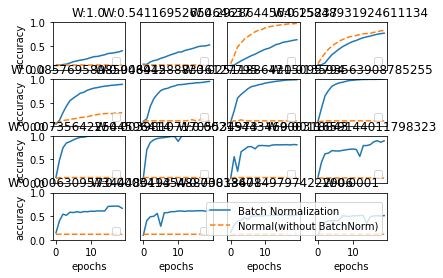

In [15]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()


# 오버 피팅
- 오버피팅은 주로 다음의 두 경우에 일어납니다.
1. 매개변수가 많고 표현력이 높은 모델
2. 훈련 데이터가 적음

epoch:0, train acc:0.13, test acc:0.1149
epoch:1, train acc:0.13333333333333333, test acc:0.1173
epoch:2, train acc:0.14, test acc:0.1246
epoch:3, train acc:0.15, test acc:0.1336
epoch:4, train acc:0.16333333333333333, test acc:0.1429
epoch:5, train acc:0.17666666666666667, test acc:0.1511
epoch:6, train acc:0.18333333333333332, test acc:0.1624
epoch:7, train acc:0.2, test acc:0.1761
epoch:8, train acc:0.21, test acc:0.1872
epoch:9, train acc:0.22666666666666666, test acc:0.1954
epoch:10, train acc:0.23, test acc:0.2023
epoch:11, train acc:0.25, test acc:0.2108
epoch:12, train acc:0.26, test acc:0.2208
epoch:13, train acc:0.26666666666666666, test acc:0.2281
epoch:14, train acc:0.28, test acc:0.2358
epoch:15, train acc:0.2966666666666667, test acc:0.2449
epoch:16, train acc:0.3, test acc:0.2468
epoch:17, train acc:0.32, test acc:0.2548
epoch:18, train acc:0.3233333333333333, test acc:0.2598
epoch:19, train acc:0.33666666666666667, test acc:0.2626
epoch:20, train acc:0.33666666666666667

epoch:159, train acc:0.8266666666666667, test acc:0.6295
epoch:160, train acc:0.82, test acc:0.6261
epoch:161, train acc:0.8233333333333334, test acc:0.6213
epoch:162, train acc:0.82, test acc:0.6324
epoch:163, train acc:0.8233333333333334, test acc:0.6252
epoch:164, train acc:0.8266666666666667, test acc:0.6318
epoch:165, train acc:0.8333333333333334, test acc:0.6326
epoch:166, train acc:0.82, test acc:0.6315
epoch:167, train acc:0.8266666666666667, test acc:0.6317
epoch:168, train acc:0.83, test acc:0.6266
epoch:169, train acc:0.8366666666666667, test acc:0.6247
epoch:170, train acc:0.8433333333333334, test acc:0.6359
epoch:171, train acc:0.8466666666666667, test acc:0.6366
epoch:172, train acc:0.8433333333333334, test acc:0.6348
epoch:173, train acc:0.8333333333333334, test acc:0.6376
epoch:174, train acc:0.8366666666666667, test acc:0.6399
epoch:175, train acc:0.8433333333333334, test acc:0.6239
epoch:176, train acc:0.84, test acc:0.641
epoch:177, train acc:0.8433333333333334, test

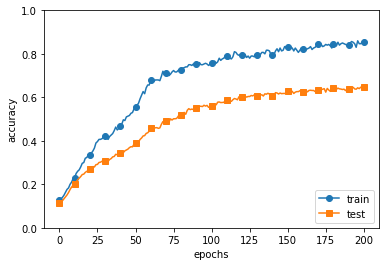

In [16]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


# 드롭아웃
- 드로아웃은 뉴런을 임의로 삭제하면서 학습하는 방법입니다. 훈련 때 은닉층의 뉴런을 무작위로 골라 삭제합니다. 삭제된 뉴런은 신호를 전달하지 않게 됩니다. 훈련때는 데이터를 흘릴 때마다 삭제할 뉴런을 무작위로 선택하고, 시험 때는 모든 뉴런에 신호를 전달합니다. 단, 시험때는 각 뉴런의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력합니다.

In [17]:
class Dropout:
    def __init__(self,dropout_ratio=0.5):
        self.dropout_ratio=dropout_ratio
        self.mask=None
        
    def forward(self,x,train_flg=True):
        if train_flg:
            self.mask=np.random.rand(*x.shape)>self.dropout_ratio
            return x*self.mask
        else:
            return x*(1.0-self.dropout_ratio)
    def backward(self,dout):
        return dout*self.mask

- 기계학습에서는 앙상블 학습 ensemble learning을 애용합니다. 앙상블 학습은 개별적으로 학습시킨 여러 모델의 출력을 평균 내어 추론하는 방식입니다. 신경망의 맥락에서 얘기하면, 가령 같은 (혹은 비슷한) 구조의 네트워크를 5개 준비하여 따로따로 학습시키고, 시험 때는 그 5개의 출력을 평균 내어 답하는 것이죠. 앙상블 학습을 수행하면 신경망의 정확도가 몇% 정도 개선된다는 것이 실험적으로 알려져 있습니다.
- 앙상블 학습은 드롭아웃과 밀접합니다. **드롭아웃이 학습 때 뉴런을 무작위로 삭제하는 행위를 매번 다른 모델을 학습시키는 것으로 해석**할 수 있기 때문이죠. 그리고 추론 때는 뉴런의 출력에 삭제한 비율(이를테면 0.5 등)을 곱합으로써 앙상블 학습에서 여러 모델의 평균을 내는 것과 같은 효과를 얻는 것이죠. 즉, 드롭아웃은 앙상블 학습과 같은 효과 (대략)하나의 네트워크로 구현했다고 생각할 수 있습니다.

- 훈련 데이터는 매개변수 (가중치와 편향)의 학습에 이용하고, 검증 데이터는 하이퍼파라미터의 성능을 평가하는 데 이용합니다. 시험 데이터는 범용 성능을 확인하기 위해서 마지막에 (이상적으로는 한 번만) 이용합니다.
1. 훈련 데이터 : 매개변수 학습
2. 검증 데이터 : 하이퍼파라미터 성능 평가
3. 시험 데이터 : 신경망의 범용 성능 평가

In [19]:
from common.util import shuffle_dataset

(x_train,t_train),(x_test,t_test)=load_mnist()

#훈련 데이터를 뒤섞는다.
x_train,t_train=shuffle_dataset(x_train,t_train)

#20%를 검증 데이터로 분할
validation_rate=0.20
validation_num=int(x_train.shape[0]*validation_rate)

x_val=x_train[:validation_num]
t_val=t_train[:validation_num]
x_train=x_train[validation_num:]
t_train=t_train[validation_num:]

# 하이퍼 파라미터 최적화
0 단계 : 하이퍼 파라미터 값의 범위를 설정합니다.  
1 단계 : 설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출합니다.  
2 단계 : 1단계에서 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 검증 데이터로 정확도를 평가합니다(단, 에폭은 작게 설정합니다).  
3 단계 : 1단계와 2단계를 특정 횟수(100회 등) 반복하며, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힙니다.

- 여기에서 설명한 하이퍼 파라미터 최적화 방법은 실용적인 방법입니다.하지만 과학이라기보다는 다분히 수행자의 '지혜'와 '직관'에 의존한다고 느낌이 들죠. 더 세련된 기법을 원한다면 베이즈 최적화 Bayesian Optimization를 소개할 수 있겠습니다. 베이즈 최적화는 베이즈 정리 Bayes' theorem를 중심으로 한 수학 이론을 구사하여 더 엄밀하고 효율적으로 최적화를 수행합니다.

val acc:0.18 | lr:0.0005438344583655799, weight decay:1.8163222752286534e-07
val acc:0.18 | lr:2.5885497031654058e-05, weight decay:7.278140364415635e-07
val acc:0.42 | lr:0.0015811399085729676, weight decay:5.786638138574523e-07
val acc:0.1 | lr:3.23719580690827e-05, weight decay:2.680070733483477e-07
val acc:0.12 | lr:4.981702202870147e-06, weight decay:1.3817341077201807e-06
val acc:0.7 | lr:0.004962479763533595, weight decay:3.878078757851781e-07
val acc:0.05 | lr:4.938060983434267e-06, weight decay:1.5806783854299568e-05
val acc:0.66 | lr:0.004365575230753083, weight decay:1.164838554012267e-08
val acc:0.11 | lr:1.0016702529508808e-06, weight decay:3.141230091513709e-06
val acc:0.08 | lr:0.00010146717628272587, weight decay:2.56840900603585e-05
val acc:0.06 | lr:0.00015234709631935977, weight decay:2.9887841388842263e-07
val acc:0.08 | lr:0.00011830708442481946, weight decay:7.701578982062861e-06
val acc:0.54 | lr:0.0024341042236563446, weight decay:1.2359380691173025e-07
val acc:

Best-15(val acc:0.42) | lr:0.0015811399085729676, weight decay:5.786638138574523e-07
Best-16(val acc:0.4) | lr:0.002379046386942085, weight decay:5.745773851497135e-06
Best-17(val acc:0.38) | lr:0.0016066737268369065, weight decay:2.2979200520412132e-07
Best-18(val acc:0.33) | lr:0.00190701401725363, weight decay:5.145985025991276e-06
Best-19(val acc:0.3) | lr:0.0006335212579606908, weight decay:1.3937820538087224e-06
Best-20(val acc:0.3) | lr:0.0010773550510922735, weight decay:6.803004127135899e-07


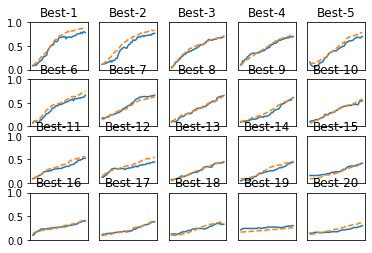

In [20]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()


1. 매개변수 갱신 방법에는 확률적 경사 하강법(SGD) 외에도 모멘텀, AdaGrad, Adam 등이 있다.
2. 가중치 초깃값을 정하는 방법은 올바른 학습을 하는 데 매우 중요하다.
3. 가중치의 초깃값으로는 'Xavier 초깃값'과 'He 초깃값'이 효과적이다.
4. 배치 정규화를 이용하면 학습을 빠르게 진행할 수 있으며, 초깃값에 영향을 덜 받게 된다.
5. 오버피팅을 억제하는 정규화 기술로는 가중치 감소와 드롭아웃이 있다.
6. 하이퍼파라미터 값 탐색은 최적 값이 존재할 법한 범위를 점차 좁히면서 하는 것이 효과적이다.